In [1]:
%cd ..
%ls

C:\Users\Dongmin Kim\Documents\OnlineTSAD
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD 디렉터리

2023-05-16  오후 01:25    <DIR>          .
2023-05-16  오후 01:25    <DIR>          ..
2023-04-10  오후 01:01               156 .gitignore
2023-05-16  오후 06:14    <DIR>          .idea
2023-04-14  오후 04:53    <DIR>          .ipynb_checkpoints
2023-05-14  오후 03:07    <DIR>          cfgs
2023-05-04  오후 08:21    <DIR>          checkpoints
2023-05-11  오후 05:27    <DIR>          data
2023-05-16  오후 01:21    <DIR>          EDA
2023-05-16  오후 02:08    <DIR>          Exp
2023-05-16  오후 04:56    <DIR>          figures
2023-05-11  오후 05:30    <DIR>          hptune
2023-05-04  오후 08:21    <DIR>          logs
2023-05-07  오후 01:57    <DIR>          models
2023-05-11  오후 04:21    <DIR>          outputs
2023-05-04  오후 08:21    <DIR>          plots
2023-05-16  오후 01:25               680 README.md
2023-05-13  오후 04:30    <DIR>          results
2023-05-09  오후 06:11    <DIR>  

In [2]:
import numpy as np
import matplotlib as mat
from matplotlib import font_manager, rc

def setPlotStyle():    
    #mat.rcParams['font.family'] = "serif"
    #mat.rcParams['font.serif'] = ["Arial"]
    mat.rcParams['font.family'] = "sans-serif"
    mat.rcParams['font.sans-serif'] = "Times new roman"
    mat.rcParams["axes.titlesize"] = "x-large"
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500
setPlotStyle()

In [3]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [4]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'SlowRevIN'
cfg["gamma"] = 0.99
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-16 18:14:58,438] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-16 18:14:58,439] Preparing SWaT dataset...
[2023-05-16 18:14:58,440] cur

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-16 18:15:07,605] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-16 18:15:07,705] Complete.
[2023-05-16 18:15:07,706] Preparing dataloader...
[2023-05-16 18:15:08,335] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-16 18:15:08,336] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-16 18:15:08,337] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


## Visualize

In [5]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
data_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


In [6]:
cols = list(data_df.columns)

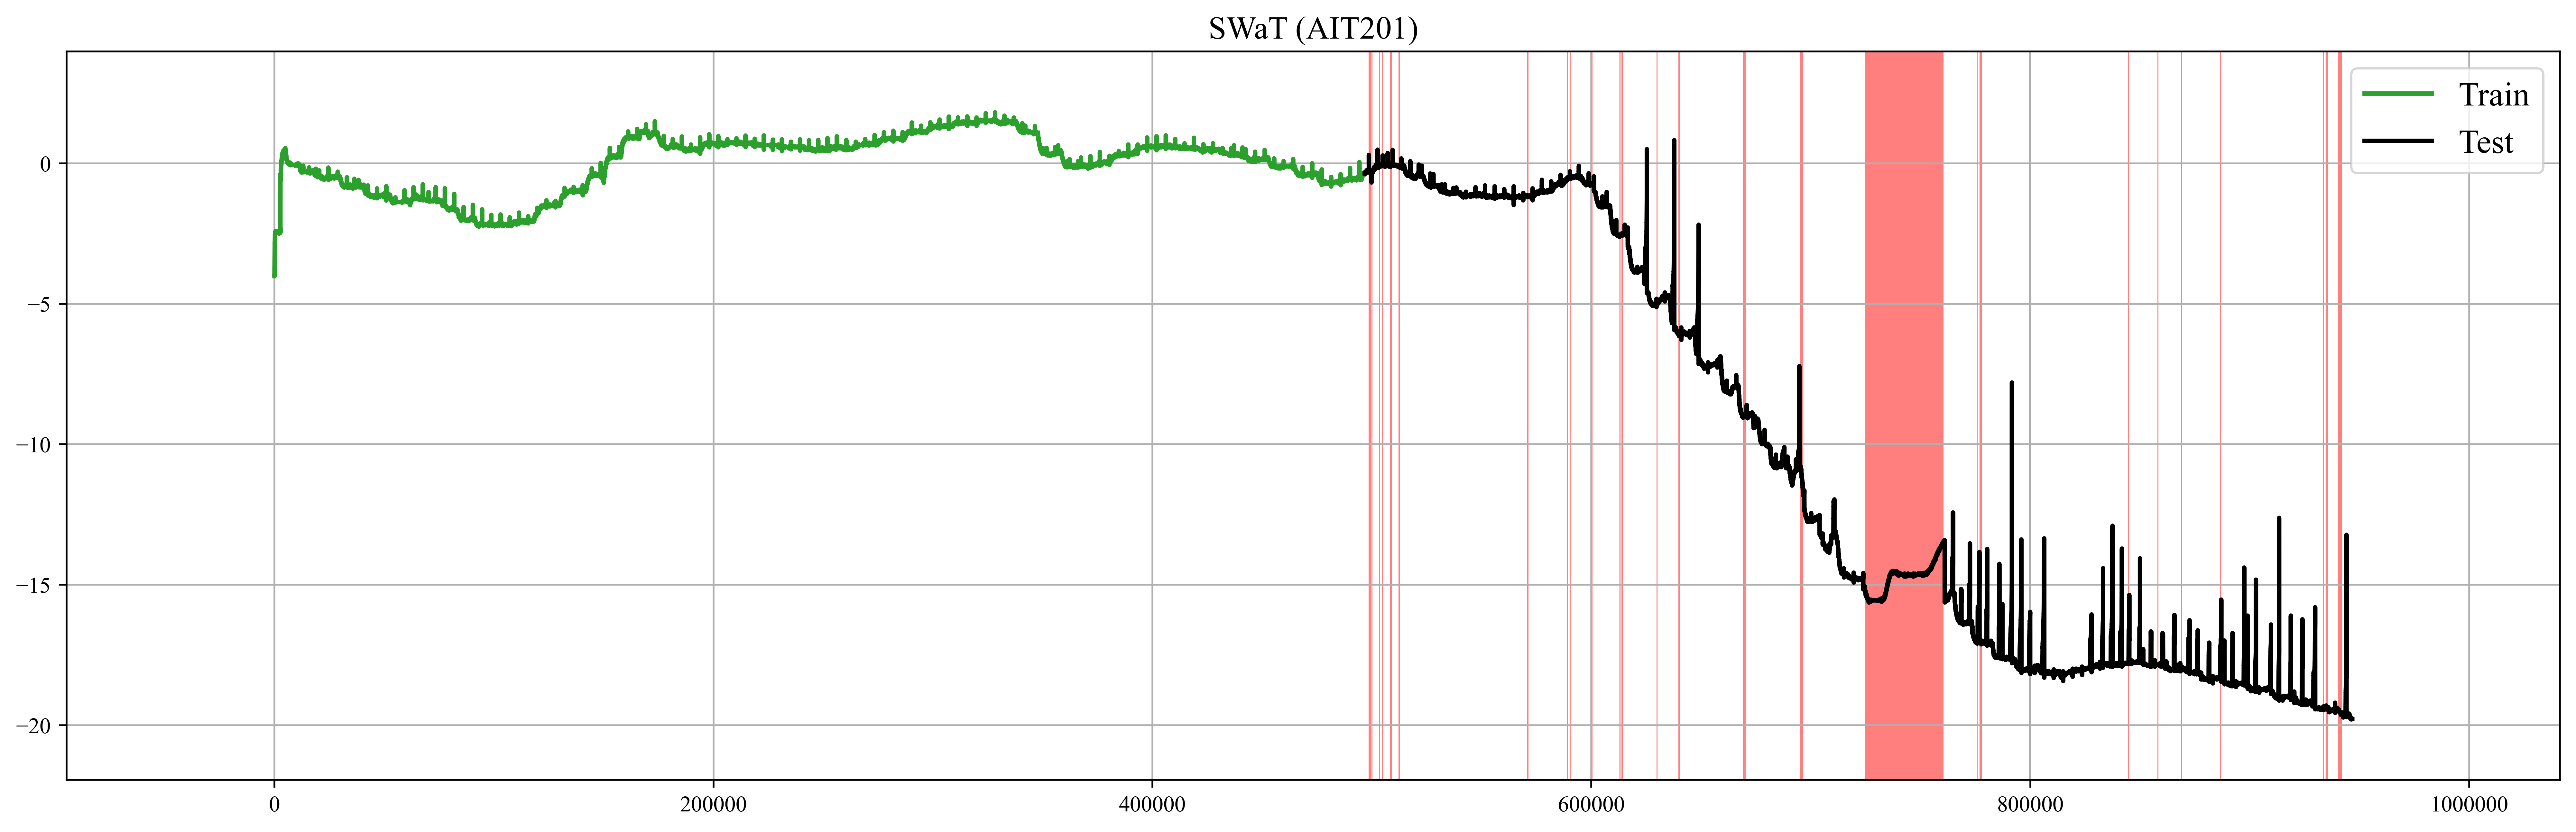

In [7]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)
#plt.title(f"{dataset_name} ({cols[c]})")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")
plt.show()

## PCA plots

In [5]:
from scipy.stats import gaussian_kde, entropy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy

In [6]:
"https://gist.github.com/ChuaCheowHuan/18977a3e77c0655d945e8af60633e4df"
def kl_mvn(to, fr):
    """Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices"""
    m_to, S_to = to
    m_fr, S_fr = fr
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2.

def plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, load=True):
    print("="*20)
    print(f"KLD for {data}")
    base_dir = os.path.join("figures", "PCA", data)
    os.makedirs(base_dir, exist_ok=True)
    
    #import pdb;pdb.set_trace();
    if (load==True) and (os.path.exists(os.path.join(base_dir, "Xpca_train.npy"))):
        Xpca_train = np.load(os.path.join(base_dir, "Xpca_train.npy"))
        Xpca_test = np.load(os.path.join(base_dir, "Xpca_test.npy"))
    else:
        print("finding PCA...")
        T, C = train_X.shape

        # filter anomalies
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        mask = (1-test_y).astype(bool)
        test_X = test_X[mask]
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        data = np.concatenate([train_X, test_X])
        print(data.shape)

        if C < 2:
            Xpca_train = train_X
            Xpca_test = test_X
        else:
            x = range(1, min(C, 31))
            d = -1
            evar = []
            for n in x:
                pca = PCA(n_components=n)
                Xpca = pca.fit_transform(data)
                evar.append(sum(pca.explained_variance_ratio_))
                if d == -1 and sum(pca.explained_variance_ratio_) > 0.99 :
                    d = n
            print("Done!")
            plt.plot(x, evar)
            plt.axvline(d)
            plt.show()

            # kde of PCA'ed outputs.
            pca = PCA(n_components=d) 
            pca_data = pca.fit_transform(data)
            Xpca_train = pca_data[:len(train_X)]
            Xpca_test = pca_data[len(train_X):]
        
        print("saving...")
        with open(os.path.join(base_dir, "Xpca_train.npy"), "wb") as f:
            np.save(f, Xpca_train)
        with open(os.path.join(base_dir, "Xpca_test.npy"), "wb") as f:
            np.save(f, Xpca_test)
            
    print("Estimating Gaussian KLD...")
    _, C = Xpca_train.shape
    train_mu = np.mean(Xpca_train, axis=0)
    test_mu = np.mean(Xpca_test, axis=0)
    train_var = np.array([[np.var(Xpca_train)]]) if C < 2 else np.cov(Xpca_train.T)
    test_var = np.array([[np.var(Xpca_test)]]) if C < 2 else np.cov(Xpca_test.T)
    train_stats = (train_mu, train_var)
    test_stats = (test_mu, test_var)
    e = kl_mvn(test_stats, train_stats)    
    print("KLD: ", e)
    print("train_stats: ", train_stats)
    print("test_stats: ", test_stats)
    print("done")
    print("="*20)
    return e, Xpca_train, Xpca_test

In [7]:
#datasets_label = ["SWaT", "WADI", "PSM", "CreditCard", "MSL\n(P-15)", "SMD\n(1-4)", "Yahoo\n(Data-20)", "Pump"]
datasets_label = ["SWaT", "WADI", "SMD\n(M-1-4)", "SMD\n(M-2-1)", 
            "MSL\n(P-15)", "SMAP\n(T-3)", "CreditCard","yahoo\n(A1-R20)", "yahoo\n(A1-R55)"]
datasets = ["SWaT", "WADI", "SMD_machine-1-4", "SMD_machine-2-1", 
            "MSL_P-15", "SMAP_T-3", "CreditCard","yahoo_20", "yahoo_55"]

In [8]:
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[0])
entropies.append(e)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[1])
entropies.append(e)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[2])
entropies.append(e)

# SMD_machine-2-1
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-2-1")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[3])
entropies.append(e)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[4])
entropies.append(e)

# SMAP
train_X, train_y, test_X, test_y = DataFactory.load_SMAP("T-3")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[5])
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[6])
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[7])
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("55")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[8])
entropies.append(e)



KLD for SWaT
Estimating Gaussian KLD...
KLD:  143.91222208812337
train_stats:  (array([ -1.6705731,   5.2914505,   7.6528034,  24.086998 , -17.860296 ,
         3.4094663], dtype=float32), array([[14969.14370043,  -983.66328347,   281.46421761,   -32.0104241 ,
           51.99849803,    67.15677732],
       [ -983.66328347, 18588.12709894,  -690.95972503,   518.08851302,
          426.54607852,   563.25074743],
       [  281.46421761,  -690.95972503,  2834.33070887,  1006.80290905,
          637.85931237,   110.76374396],
       [  -32.0104241 ,   518.08851302,  1006.80290905,  3749.17332058,
         1331.5161391 ,  -206.2802673 ],
       [   51.99849803,   426.54607852,   637.85931237,  1331.5161391 ,
          560.95310297,    80.69730099],
       [   67.15677732,   563.25074743,   110.76374396,  -206.2802673 ,
           80.69730099,   520.23971867]]))
test_stats:  (array([  2.7904286,  -6.267043 , -10.202734 , -29.617435 ,  22.932138 ,
         0.5329458], dtype=float32), array([[

[2023-05-16 18:15:24,886] NumExpr defaulting to 8 threads.


KLD for WADI
Estimating Gaussian KLD...
KLD:  388179916.27252877
train_stats:  (array([ 493.81198  , -616.29034  ,   -6.9999986], dtype=float32), array([[6336939.06572379, 3212155.65095286,    6389.56469381],
       [3212155.65095286, 1628276.52011871,    7336.56831953],
       [   6389.56469381,    7336.56831953,  308618.17812147]]))
test_stats:  (array([-2629.9502  ,  2839.88    ,    30.304129], dtype=float32), array([[ 3316272.35922948, -6541580.24514296,    65568.27292287],
       [-6541580.24514296, 12904091.78971436,  -142205.10092488],
       [   65568.27292287,  -142205.10092488,   467817.21715107]]))
done
KLD for SMD_machine-1-4
Estimating Gaussian KLD...
KLD:  130.35713157389716
train_stats:  (array([ 0.05024168, -0.14805853,  0.02299842, -0.00372195, -0.01595101,
        0.00779433], dtype=float32), array([[ 4.81363737e-01,  1.47818188e-02,  8.92173929e-03,
         8.18539992e-04, -3.98136810e-03, -3.51373837e-04],
       [ 1.47818188e-02,  2.78370543e-02, -5.20829167e-03,


KLD for CreditCard
Estimating Gaussian KLD...
KLD:  0.0010342001914978027
train_stats:  (array([2.3955376], dtype=float32), array([[60743.574]], dtype=float32))
test_stats:  (array([-2.3459609], dtype=float32), array([[64353.152]], dtype=float32))
done
KLD for yahoo_20
Estimating Gaussian KLD...
KLD:  3.6281328201293945
train_stats:  (array([0.88975006], dtype=float32), array([[0.06670094]], dtype=float32))
test_stats:  (array([0.19644085], dtype=float32), array([[0.0478031]], dtype=float32))
done
KLD for yahoo_55
Estimating Gaussian KLD...
KLD:  1.069640874862671
train_stats:  (array([1867.2775], dtype=float32), array([[141839.12]], dtype=float32))
test_stats:  (array([1335.1018], dtype=float32), array([[231621.75]], dtype=float32))
done


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
datasets_label

['SWaT',
 'WADI',
 'SMD\n(M-1-4)',
 'SMD\n(M-2-1)',
 'MSL\n(P-15)',
 'SMAP\n(T-3)',
 'CreditCard',
 'yahoo\n(A1-R20)',
 'yahoo\n(A1-R55)']

In [21]:
entropies

[143.91222208812337,
 388179916.27252877,
 130.35713157389716,
 6.233628718874224,
 743.2572253055034,
 2.927400304736665,
 0.0010342001914978027,
 3.6281328201293945,
 1.069640874862671]

,Datasets,KLD
0,SWaT,1.439122e+02
1,WADI,3.881799e+08
2,SMD\n(M-1-4),1.303571e+02
3,SMD\n(M-2-1),6.233629e+00
4,MSL\n(P-15),7.432572e+02
5,SMAP\n(T-3),2.927400e+00
6,CreditCard,1.034200e-03
7,yahoo\n(A1-R20),3.628133e+00
8,yahoo\n(A1-R55),1.069641e+00


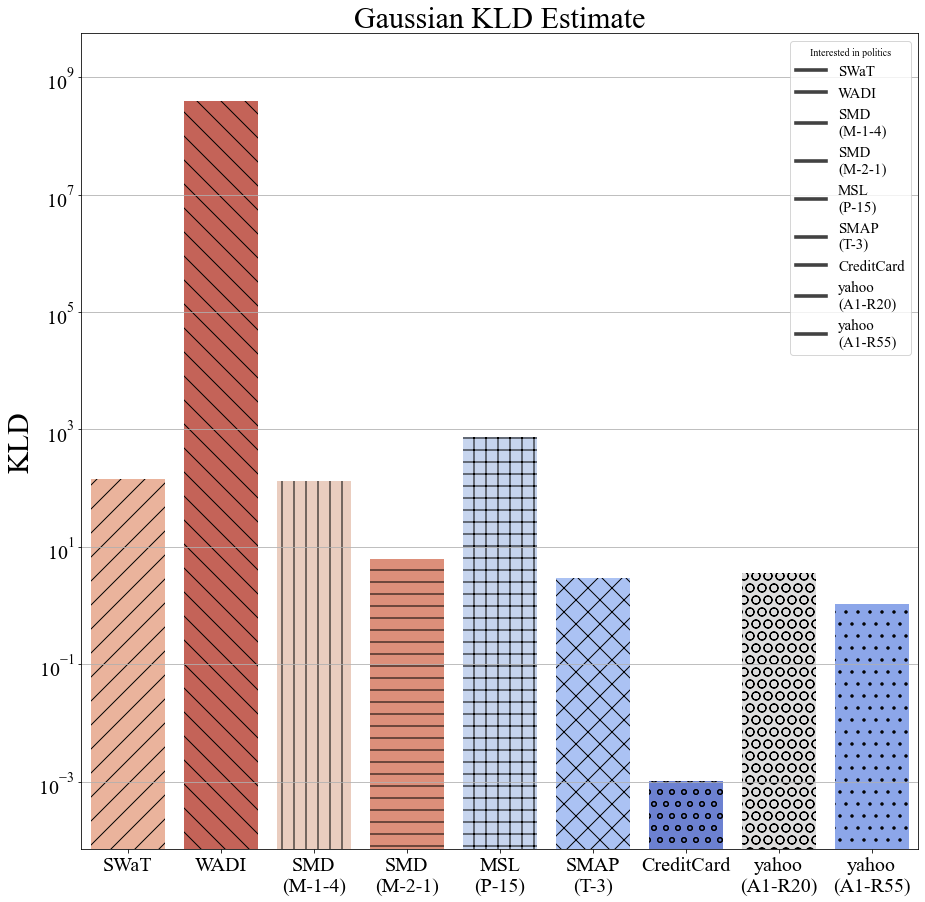

In [19]:
plt.figure(figsize=(15, 15))
plt.title('Gaussian KLD Estimate', fontsize=30)

pal = sns.color_palette("coolwarm", len(entropies))
rank = np.array(entropies).argsort()  # http://stackoverflow.com/a/6266510/1628638

#bar = sns.barplot(x=datasets_label, y=entropies, palette=np.array(pal[::])[rank], alpha=.99)

bar = sns.barplot(x="Datasets"datasets_label, y=entropies, palette=np.array(pal[::])[rank], alpha=.99)
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.']
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.yscale('log', base=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel('KLD', fontsize=30)

h, l = bar.get_legend_handles_labels()
bar.legend(datasets_label, title="Interested in politics")

#plt.legend(labels=datasets_label, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("./figures/main_figure/kld.pdf", dpi=500)
plt.show()

In [23]:
pd.DataFrame({"Datasets": datasets_label, "KLD": entropies})

,Datasets,KLD
0,SWaT,1.439122e+02
1,WADI,3.881799e+08
2,SMD\n(M-1-4),1.303571e+02
3,SMD\n(M-2-1),6.233629e+00
4,MSL\n(P-15),7.432572e+02
5,SMAP\n(T-3),2.927400e+00
6,CreditCard,1.034200e-03
7,yahoo\n(A1-R20),3.628133e+00
8,yahoo\n(A1-R55),1.069641e+00


In [37]:
df = pd.DataFrame({"Datasets": datasets_label, "KLD": entropies})
df

,Datasets,KLD
0,SWaT,1.439122e+02
1,WADI,3.881799e+08
2,SMD\n(M-1-4),1.303571e+02
3,SMD\n(M-2-1),6.233629e+00
4,MSL\n(P-15),7.432572e+02
5,SMAP\n(T-3),2.927400e+00
6,CreditCard,1.034200e-03
7,yahoo\n(A1-R20),3.628133e+00
8,yahoo\n(A1-R55),1.069641e+00


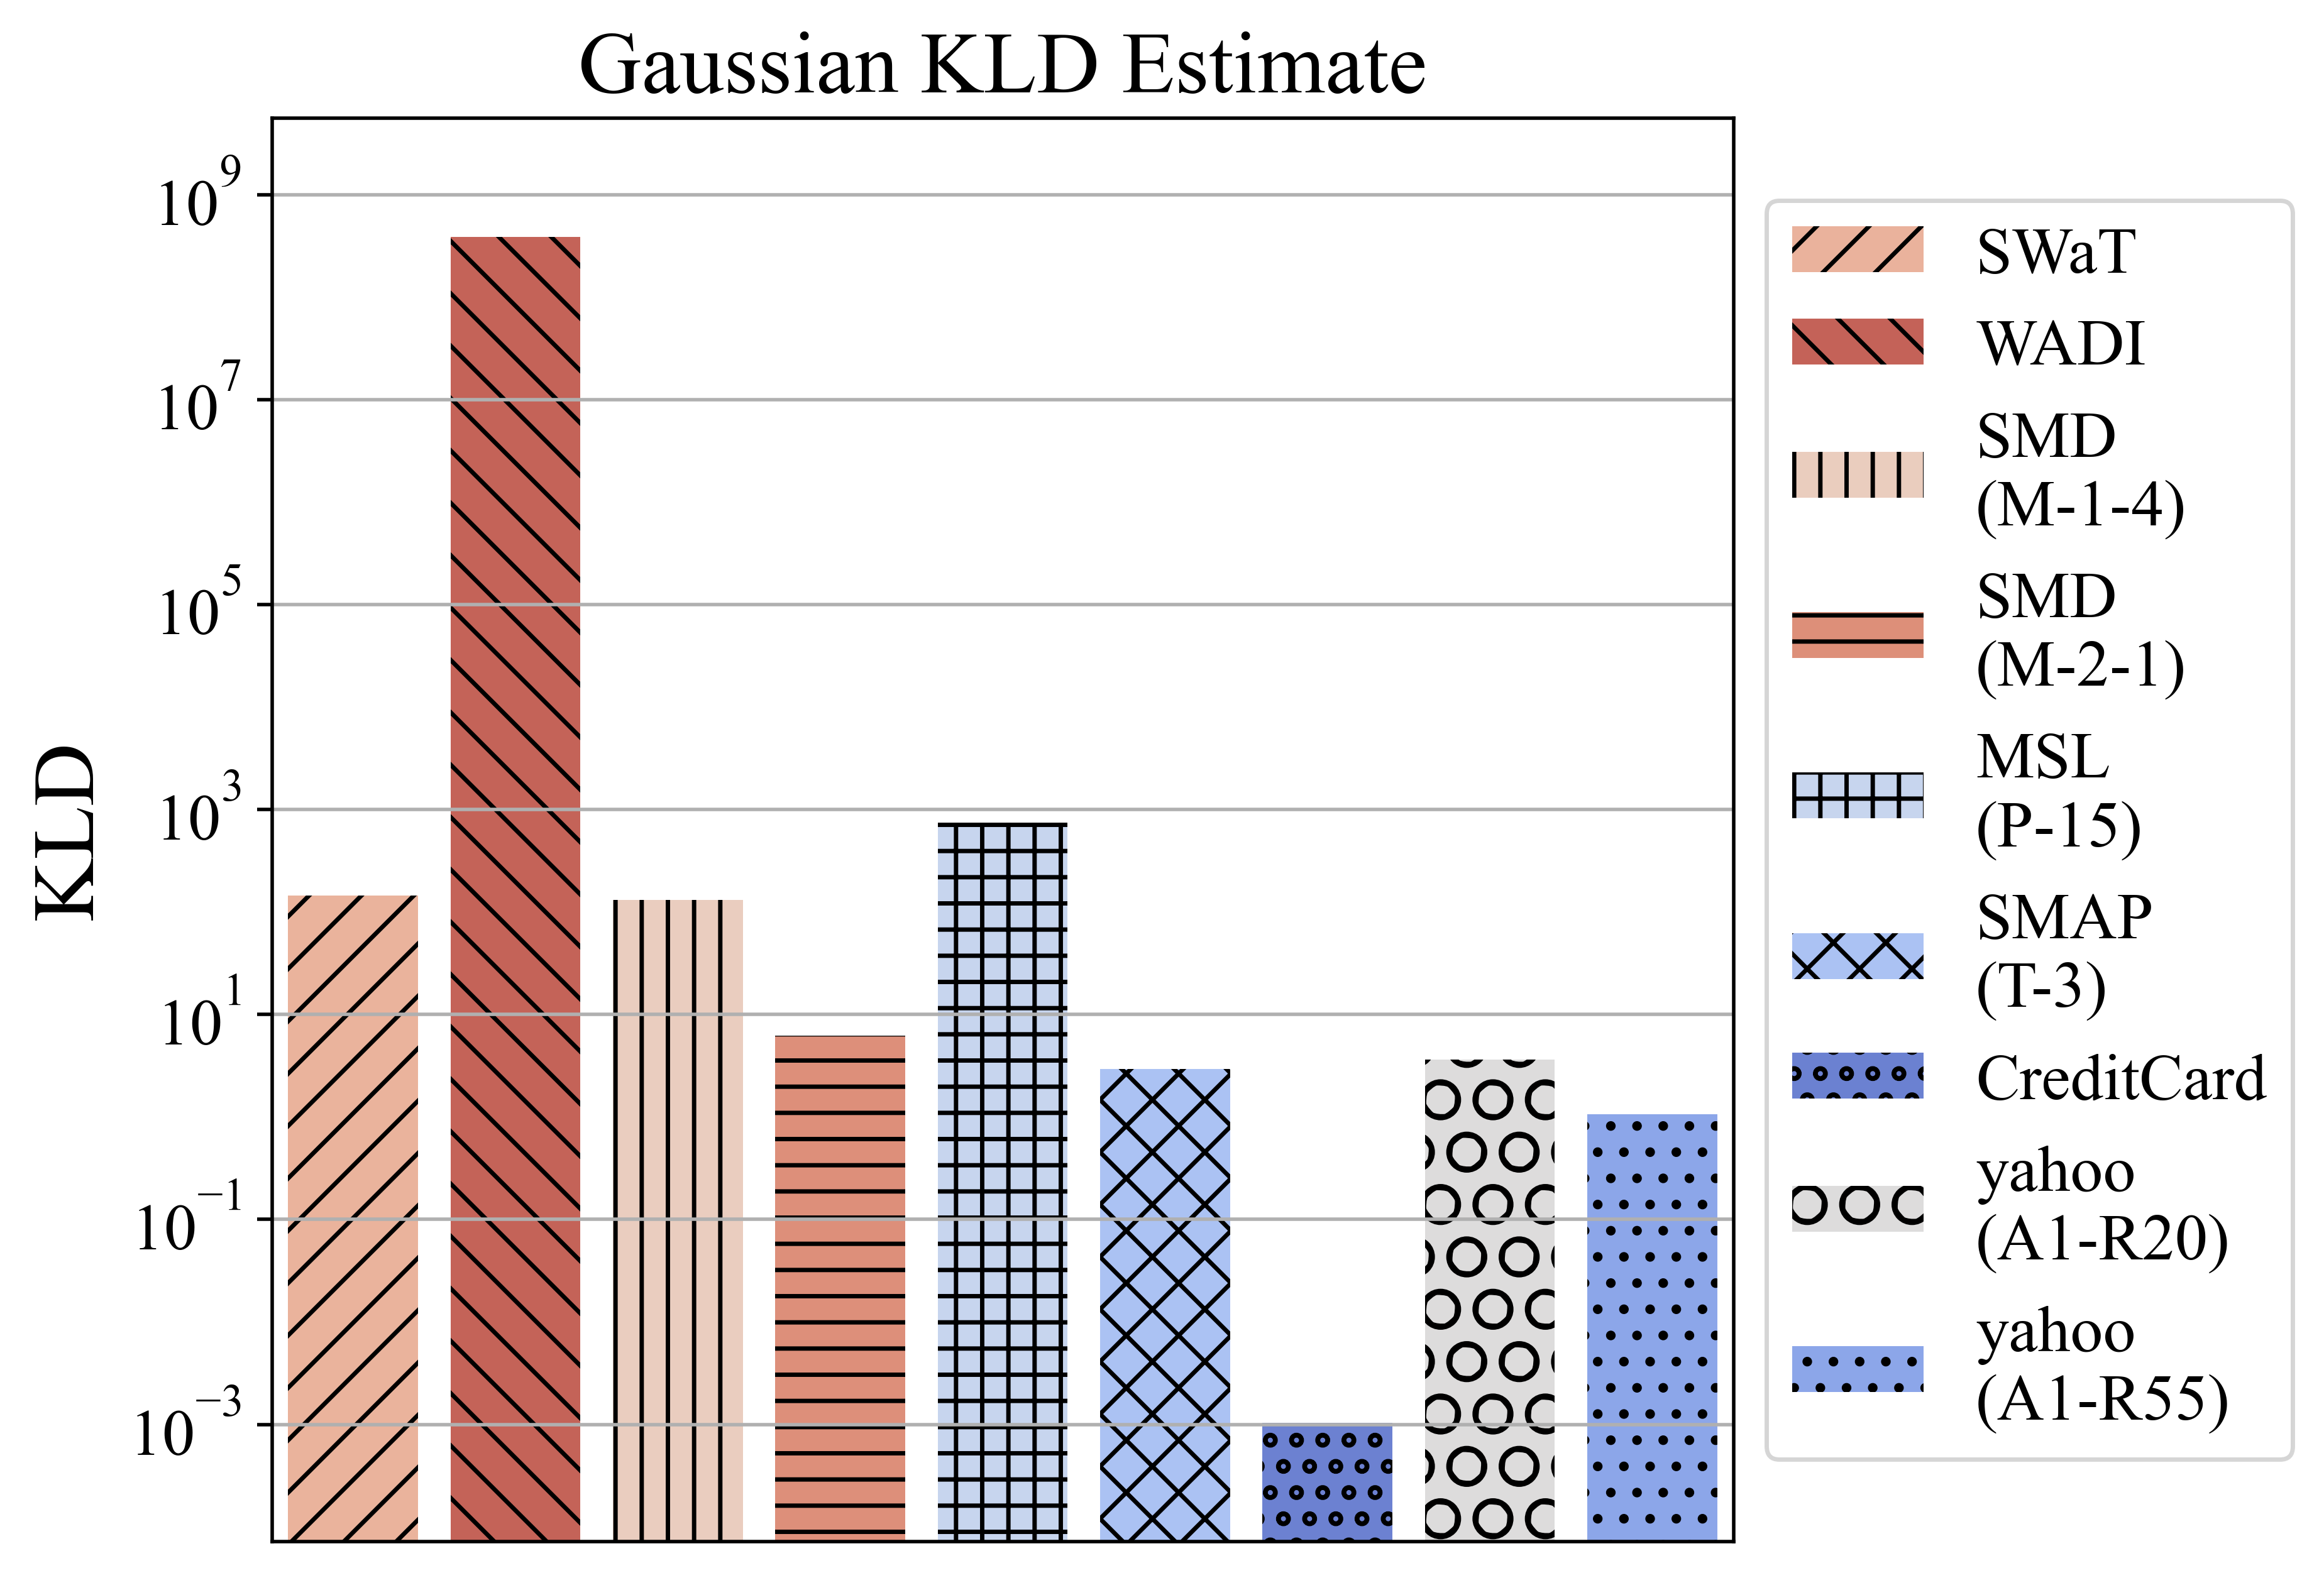

In [56]:
plt.figure(figsize=(6, 6), dpi=500)
plt.title('Gaussian KLD Estimate', fontsize=20)

pal = sns.color_palette("coolwarm", len(entropies))
rank = np.array(entropies).argsort()  # http://stackoverflow.com/a/6266510/1628638

bar = sns.barplot(x=datasets_label, y=entropies, palette=np.array(pal[::])[rank], alpha=.99)

#bar = sns.barplot(x="Datasets", y="KLD", data=pd.DataFrame({"Datasets": datasets_label, "KLD": entropies}),
#                  palette=np.array(pal[::])[rank], alpha=.99)

hatches = ['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'O0', '..']
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_label(datasets_label[i])
    thisbar.set_hatch(hatches[i])
plt.yscale('log', base=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('KLD', fontsize=20)

bar.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(True)
#ax.set(xlabel=None)
#ax.xaxis.set_tick_params(labelsize=30)
#ax.yaxis.label.set_fontsize(30)
#ax.yaxis.set_tick_params(labelsize=30)


#h, l = bar.get_legend_handles_labels()
#bar.legend(datasets_label, title="Interested in politics")

bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
#plt.legend(labels=datasets_label, )
plt.savefig("./figures/main_figure/kld.pdf", dpi=500,  bbox_inches = "tight")
plt.show()

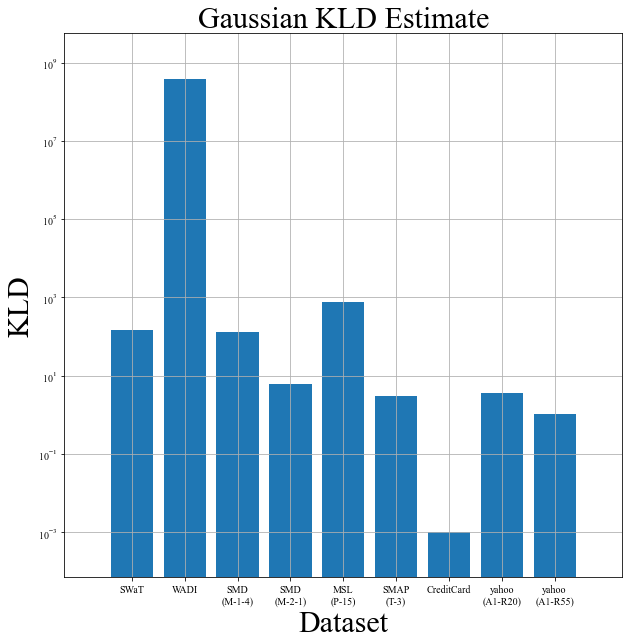

In [18]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(datasets_label, entropies)
plt.title('Gaussian KLD Estimate', fontsize=30)
plt.xlabel('Dataset', fontsize=30)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=30)
plt.show()

In [62]:
with open(os.path.join("figures", "PCA", "KLD.npy"), "wb") as f:
    np.save(f, entropies)

In [63]:
kld = np.load(os.path.join("figures", "PCA", "KLD.npy"))

In [64]:
kld

array([1.43912222e+02, 3.88179916e+08, 3.70687401e+01, 1.03420019e-03,
       7.43257245e+02, 1.30357132e+02, 3.62813282e+00, 3.62813282e+00])

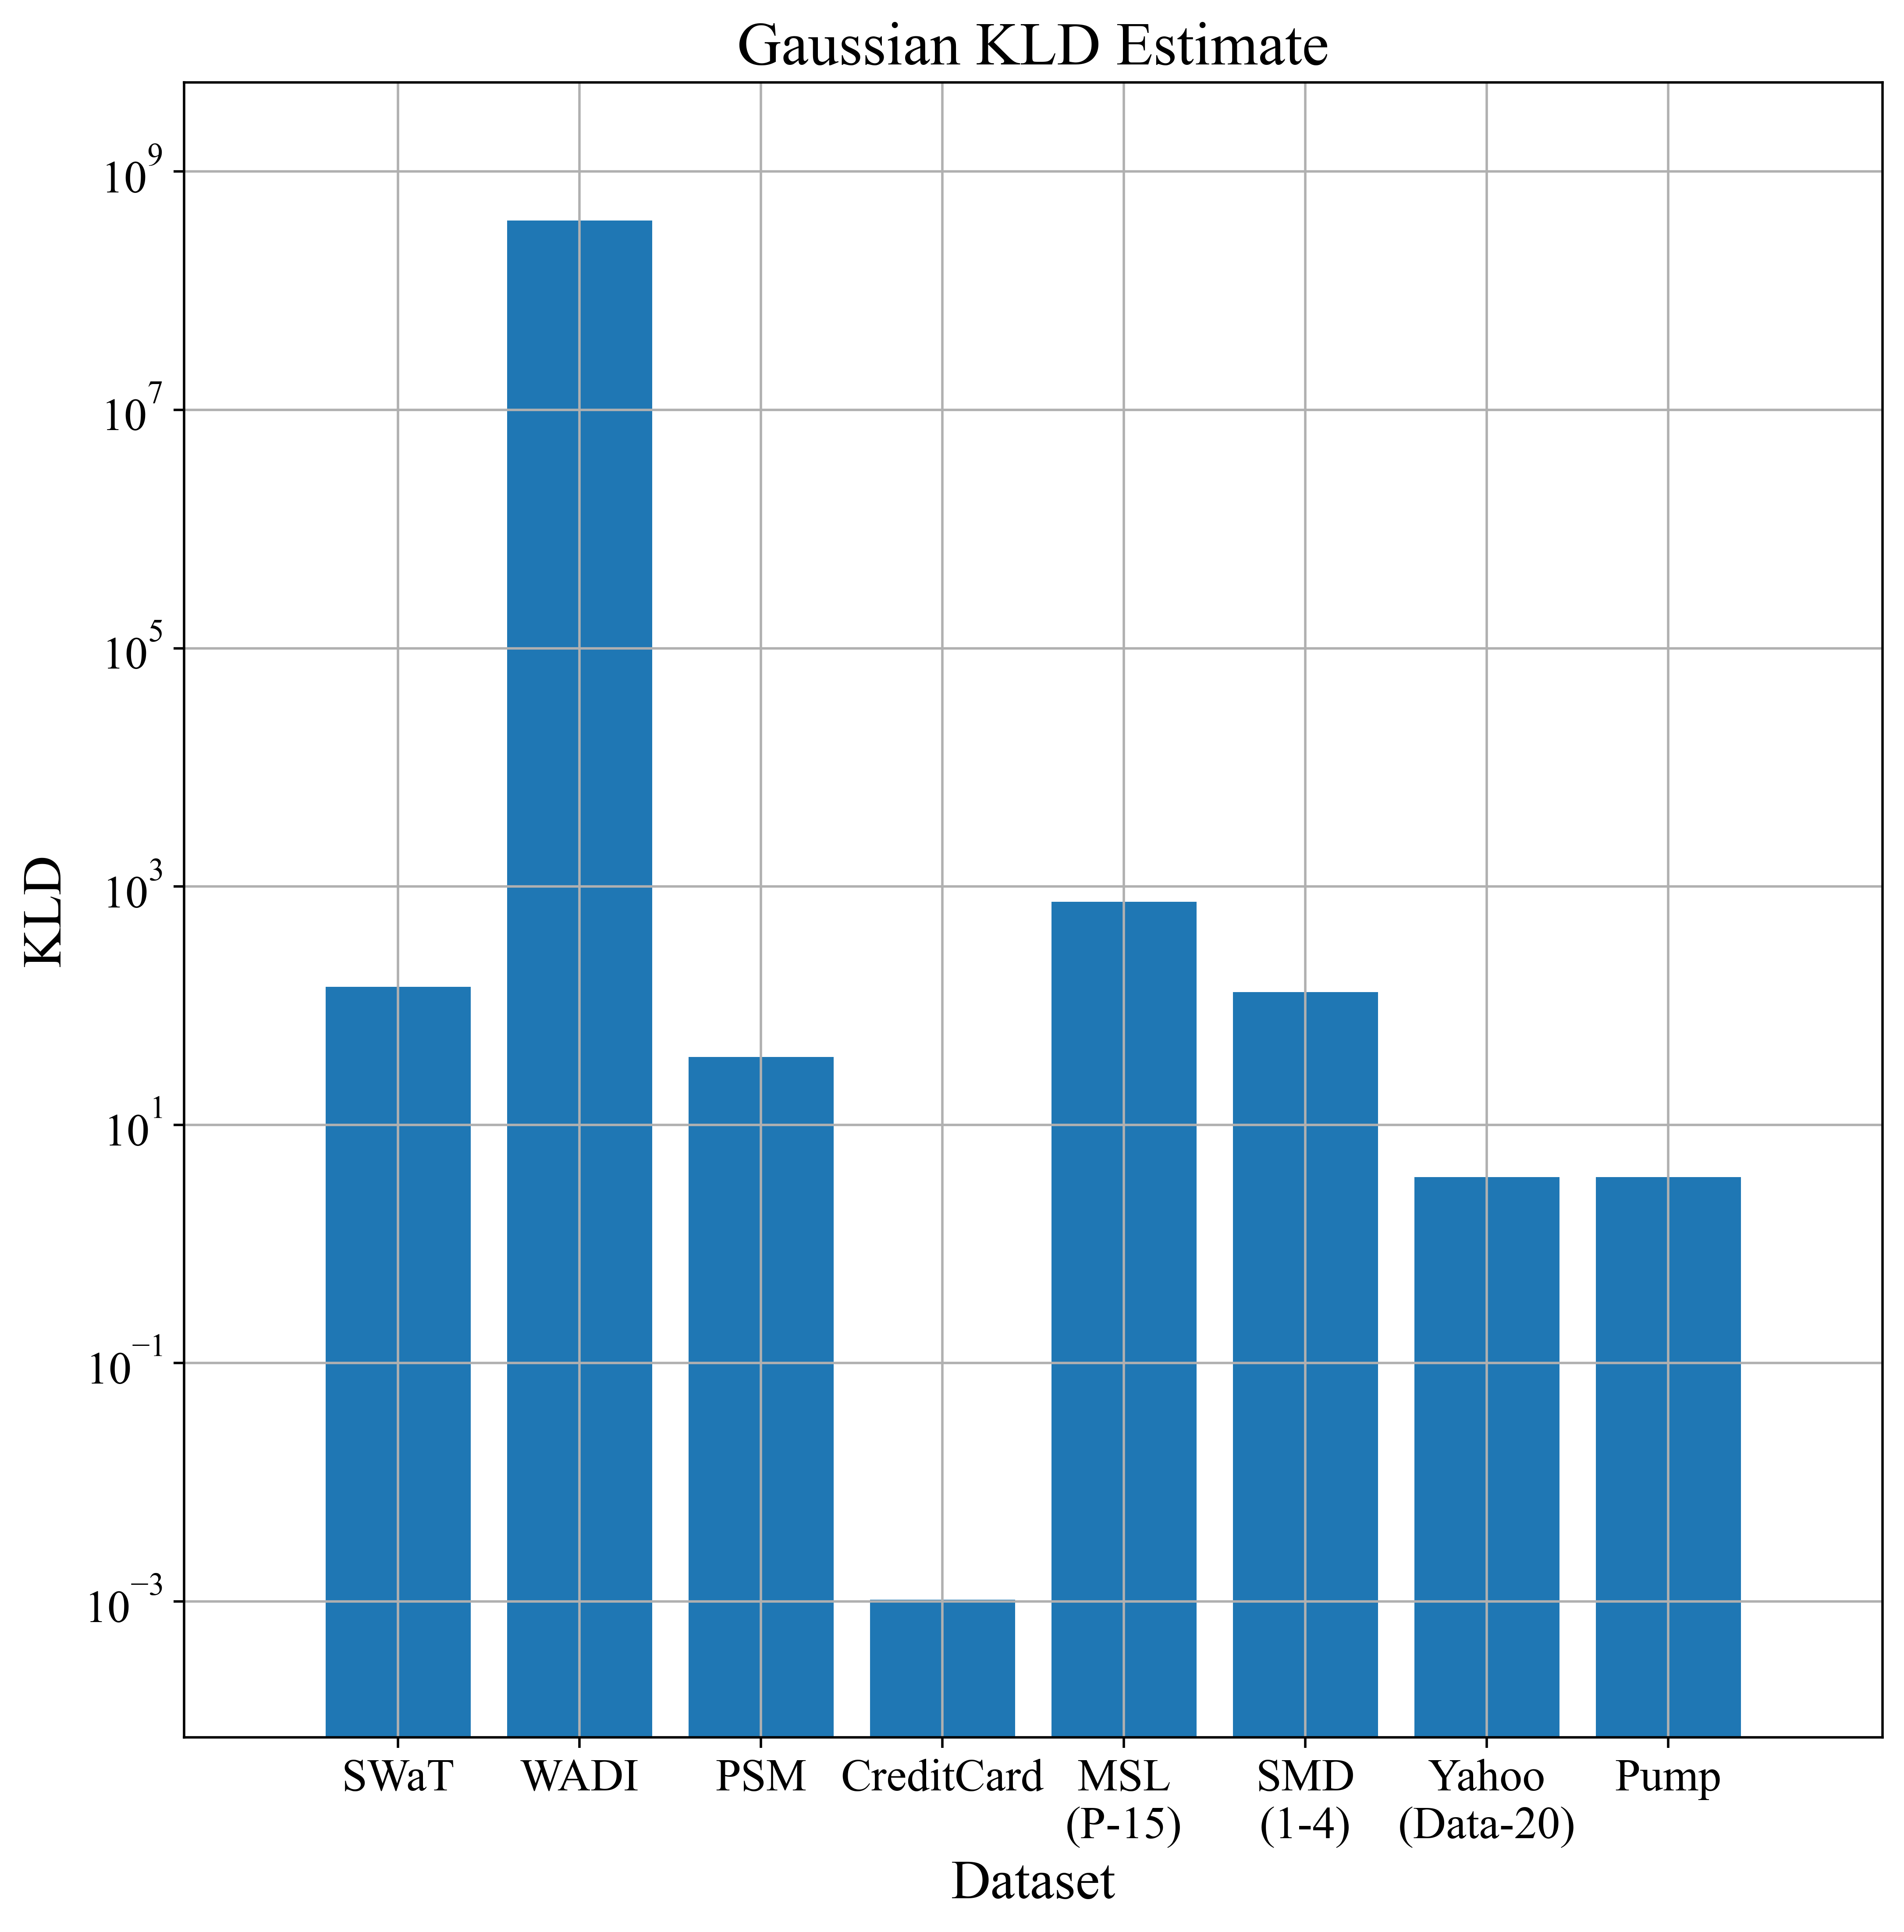

In [66]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(datasets_label, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()

In [80]:
off = np.array([0.7627829568, 0.1301139533, 0.5359979503, 0.1486068111, 0.358974359, 0.1, 0.06342913776, 0.1])
on = np.array([0.7903205183, 0.1422824922, 0.5375672963, 0.1009753299, 0.6153846154, 0.3, 0.6571428571428571, 0.3])

In [81]:
len(kld)

8

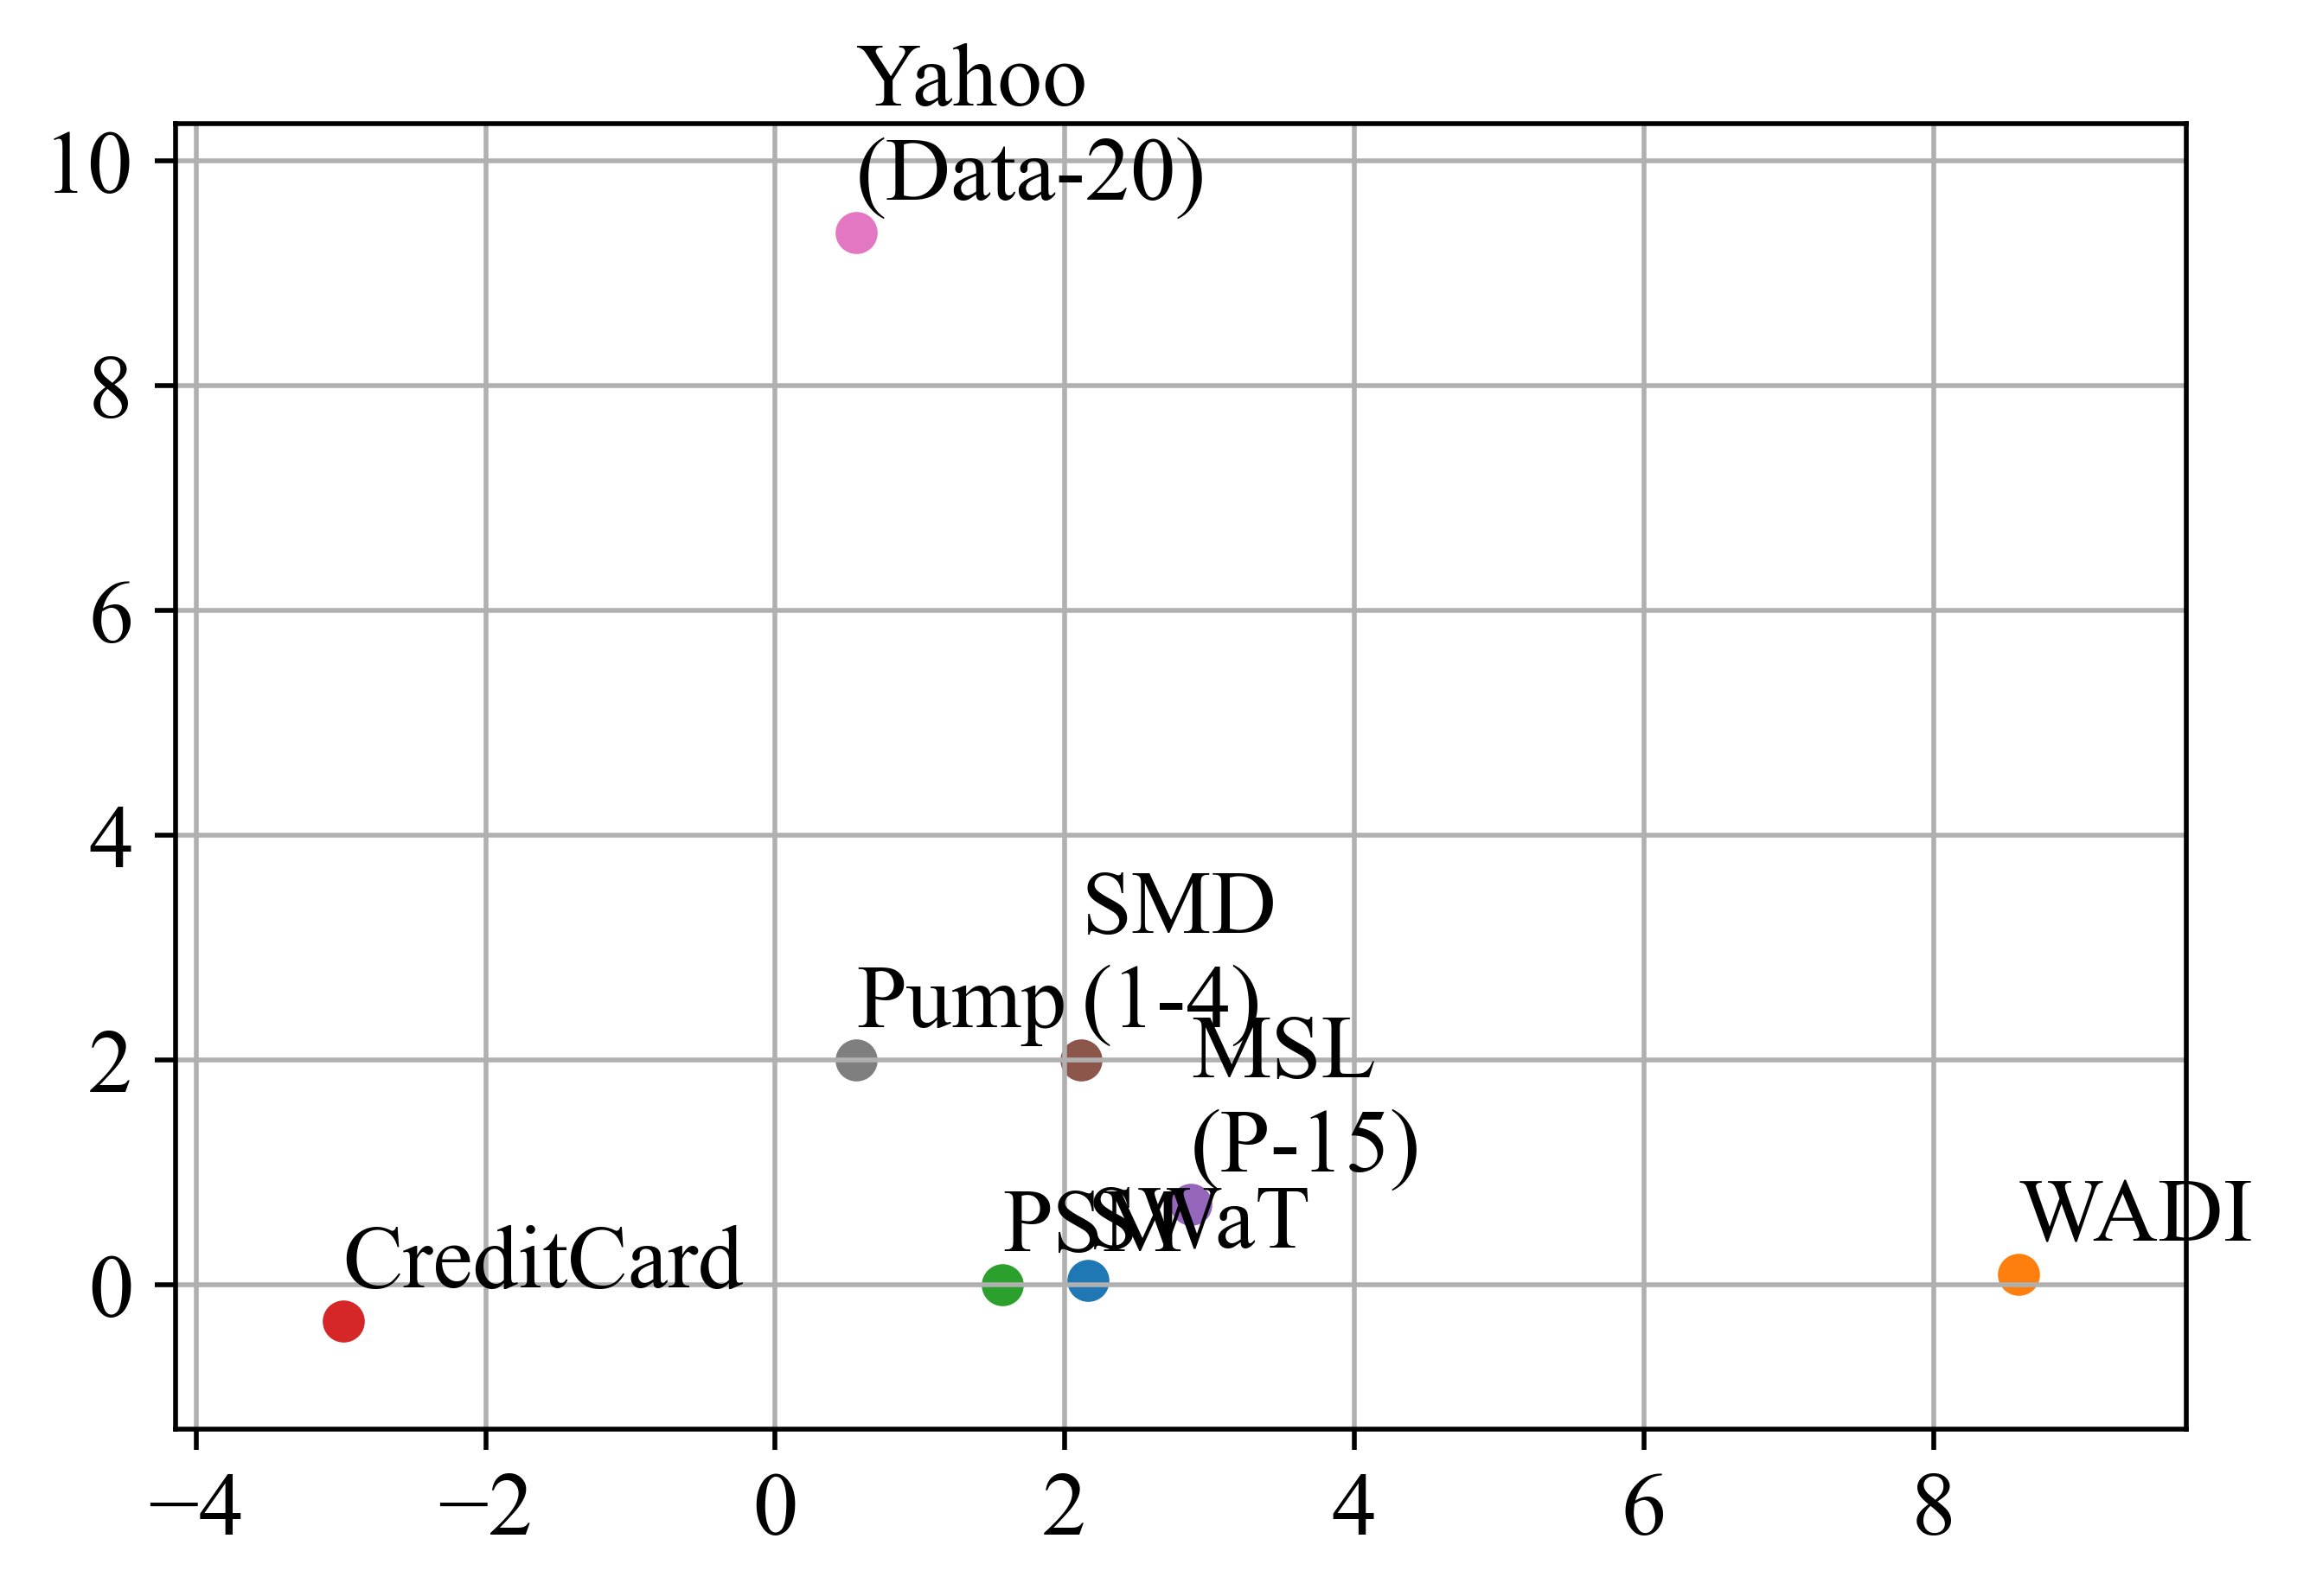

In [82]:
for x, y, data in zip(np.log10(kld), (on-off)/off, datasets_label):
    plt.scatter(x, y)
    plt.text(x, y+0.3, data)